In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import lmfit as lm
import pandas as pd

SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

print(plt.style.available)
plt.style.use('seaborn-white')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [2]:
instability = pd.read_csv("For_Helmut/For_Helmut_1.csv")
instability[:5]

,Age,Instability Mean,Instability Std,Group Size
0,18.0,0.245675,0.006825,5
1,19.0,0.218225,0.005726,3
2,20.0,0.246581,0.011646,3
3,22.0,0.234449,0.008648,3
4,23.0,0.235580,0.004252,5


In [3]:
instability["Instability SE"] = instability["Instability Std"]
instability["Instability Std"] = instability["Instability Std"]*np.sqrt(instability["Group Size"])
instability[:5]

,Age,Instability Mean,Instability Std,Group Size,Instability SE
0,18.0,0.245675,0.015261,5,0.006825
1,19.0,0.218225,0.009917,3,0.005726
2,20.0,0.246581,0.020172,3,0.011646
3,22.0,0.234449,0.014978,3,0.008648
4,23.0,0.235580,0.009508,5,0.004252


In [4]:
instability["Group Size"].sum()

634

<ErrorbarContainer object of 3 artists>

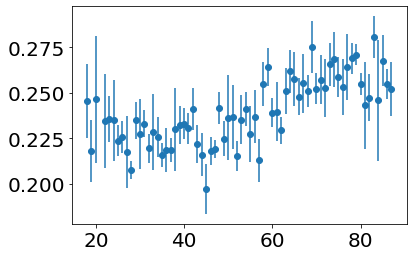

In [5]:
plt.errorbar(instability["Age"],
             instability["Instability Mean"],
             yerr=3*instability["Instability SE"],
             fmt="o")

In [6]:
def sigmoid(x,off,ampl,switchpoint,width):
    return off + ampl/(1+np.exp(-(x-switchpoint)/width))

In [34]:
sigmoid_Model = lm.Model(sigmoid)
pars = sigmoid_Model.make_params()
pars['off'].set(value=instability["Instability Mean"].min(),vary=True)
pars['ampl'].set(value=instability["Instability Mean"].max()-instability["Instability Mean"].min(),vary=True)
pars['switchpoint'].set(value=50,vary=True)
pars['width'].set(value=.1,vary=True)

out = sigmoid_Model.fit(instability["Instability Mean"], pars, x=instability["Age"], weights=1/instability["Instability Std"])
print(out.fit_report(min_correl=0.25))

[[Model]]
    Model(sigmoid)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 91
    # data points      = 69
    # variables        = 4
    chi-square         = 69.4089888
    reduced chi-square = 1.06783060
    Akaike info crit   = 8.40778143
    Bayesian info crit = 17.3442074
[[Variables]]
    off:          0.22336927 +/- 0.00208460 (0.93%) (init = 0.1973084)
    ampl:         0.03689264 +/- 0.00399131 (10.82%) (init = 0.08328854)
    switchpoint:  60.0793180 +/- 1.96728571 (3.27%) (init = 50)
    width:        4.32637045 +/- 1.85546195 (42.89%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.250)
    C(off, ampl)        = -0.640
    C(ampl, width)      =  0.605
    C(off, width)       = -0.434
    C(off, switchpoint) =  0.290


In [35]:
switchpoint = out.params['switchpoint'].value
width = out.params['width'].value
off = out.params['off'].value
ampl = out.params['ampl'].value
interval_90=np.log((1-0.05)/0.05)
afrom = (switchpoint-interval_90*width,0.19)
ato = (switchpoint+interval_90*width,0.19)
print(interval_90*width)

12.738733798193023


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  app.launch_new_instance()
/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later


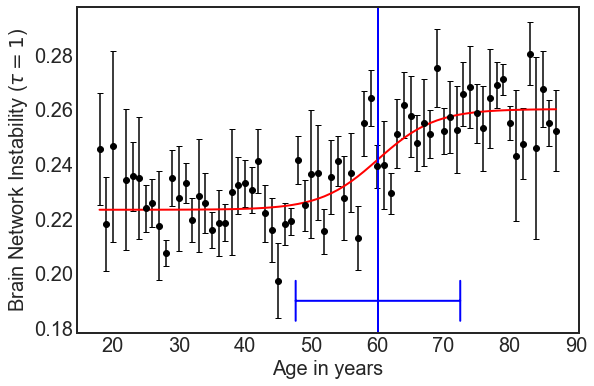

In [29]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
plt.errorbar(instability["Age"],
             instability["Instability Mean"],
             yerr=3*instability["Instability SE"],
             fmt="o",
             color="black",
#             alpha=0.5,
            capsize=3)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
#plt.plot(instability_clean["Age"], out.init_fit, 'k--')
plt.plot(instability["Age"], out.best_fit, 'r-',linewidth=2)
plt.xlabel("Age in years")
plt.ylabel(r"Brain Network Instability ($\tau=1$)")
plt.annotate(s='', xy=afrom, xytext=ato, arrowprops=dict(arrowstyle='|-|',linewidth=2,color="b"))
plt.axvline(x=switchpoint, color ='b',linewidth=2)
plt.savefig("Instability_tau_1_3SE.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")
plt.savefig("Instability_tau_1_3SE.pdf",format='pdf',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

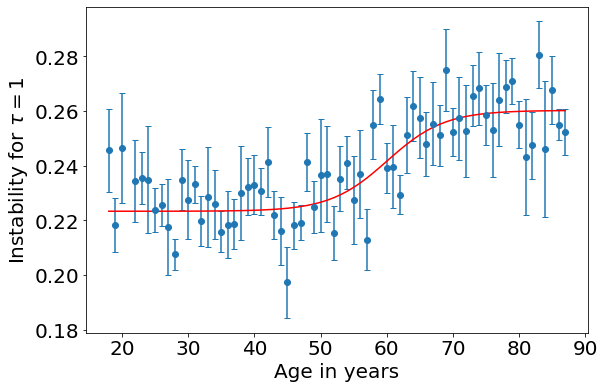

In [10]:
plt.figure(figsize=(9,6))
plt.errorbar(instability["Age"],
             instability["Instability Mean"],
             yerr=instability["Instability Std"],
             fmt="o",
             capsize=3)
#plt.plot(instability_clean["Age"], out.init_fit, 'k--')
plt.plot(instability["Age"], out.best_fit, 'r-')
plt.xlabel("Age in years")
plt.ylabel(r"Instability for $\tau=1$")
plt.savefig("Instability_tau_1_SD.png")

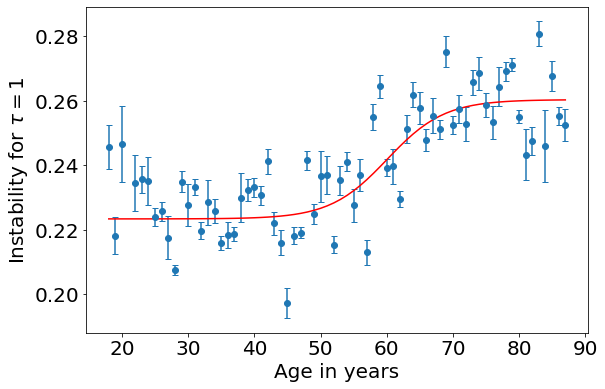

In [11]:
plt.figure(figsize=(9,6))
plt.errorbar(instability["Age"],
             instability["Instability Mean"],
             yerr=instability["Instability SE"],
             fmt="o",
            capsize=3)
#plt.plot(instability_clean["Age"], out.init_fit, 'k--')
plt.plot(instability["Age"], out.best_fit, 'r-')
plt.xlabel("Age in years")
plt.ylabel(r"Instability for $\tau=1$")
plt.savefig("Instability_tau_1_SE.png")

In [12]:
linmod = lm.models.LinearModel()
linpars = linmod.guess(instability["Instability Mean"], x=instability["Age"])
outlin = linmod.fit(instability["Instability Mean"],linpars,x=instability["Age"],weights=1/instability["Instability Std"])
print(outlin.fit_report(min_correl=0.25))                    

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 69
    # variables        = 2
    chi-square         = 93.2197317
    reduced chi-square = 1.39133928
    Akaike info crit   = 24.7588507
    Bayesian info crit = 29.2270637
[[Variables]]
    slope:      6.9641e-04 +/- 7.3325e-05 (10.53%) (init = 0.0006308851)
    intercept:  0.20069791 +/- 0.00409569 (2.04%) (init = 0.2064562)
[[Correlations]] (unreported correlations are < 0.250)
    C(slope, intercept) = -0.931


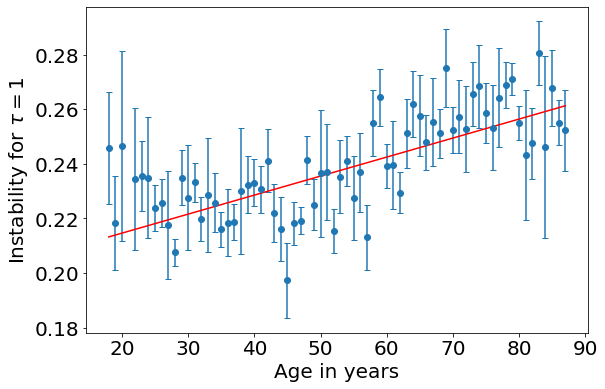

In [13]:
plt.figure(figsize=(9,6))
plt.errorbar(instability["Age"],
             instability["Instability Mean"],
             yerr=3*instability["Instability SE"],
             fmt="o",
            capsize=3)
#plt.plot(instability_clean["Age"], out.init_fit, 'k--')
plt.plot(instability["Age"], outlin.best_fit, 'r-')
plt.xlabel("Age in years")
plt.ylabel(r"Instability for $\tau=1$")
plt.savefig("Instability_tau_1_3SE_lin.png")

In [14]:
(1.39133928-1.06783060)/1.06783060

0.30295880264154257

53.08080808080808 0.2423123404391826


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:101: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:102: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


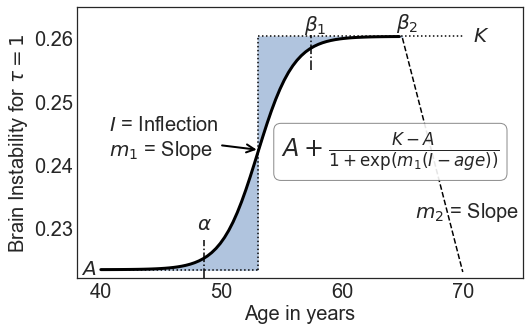

In [317]:
agex = np.linspace(40,75,100)
agec = [65,70]
bic = [0.26,0.223]
myparam = sigmoid_Model.make_params()
myparam['off'].set(value=0.22336927)
myparam['ampl'].set(value=0.03689264)
myparam['switchpoint'].set(value=53)
myparam['width'].set(value=1.5)
onset = interval_90*myparam['width']
sig1 = sigmoid_Model.eval(myparam, x=agex)
shift_params = myparam.copy()
shift_params['switchpoint'].set(value=myparam['switchpoint'] +10)
sig2 = sigmoid_Model.eval(shift_params, x=agex)

plt.figure(figsize=(8,5))
ax = plt.gca()
topoint = 71
plt.plot(agex[:topoint],sig1[:topoint],color="k",linewidth=3,label=r"glucose")
plt.plot(agec,bic,"k--")
ind = 37
eq_pointx, eq_pointy = (agex)[ind],sig1[ind]
print(eq_pointx,eq_pointy)
# plt.annotate(r"$A+\frac{K-A}{1+\exp\left(B(I-age)\right)}$",
#              xy=(eq_pointx,eq_pointy),
#              xycoords='data',
#              xytext=(20, 0),
#              textcoords='offset points',
#             size=28)
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
ax.text(64, 0.242, r"$A+\frac{K-A}{1+\exp\left(m_{1}(I-age)\right)}$", 
        ha="center", va="center", size=24,
        bbox=bbox_props)
a_pointx, a_pointy = (agex)[0],sig1[0]
plt.annotate(r"$A$",
             xy=(a_pointx,a_pointy),
             xycoords='data',
             xytext=(-20, -5),
             textcoords='offset points')
k_pointx, k_pointy = (agex)[-1],sig1[-1]
plt.annotate(r"$K$",
             xy=(k_pointx,k_pointy),
             xycoords='data',
             xytext=(-50, -5),
             textcoords='offset points')

i_pointx, i_pointy = (agex)[37],sig1[37]
plt.annotate(r"$I$ = Inflection""\n"r"$m_1$ = Slope",
             xy=(i_pointx,i_pointy),
             xycoords='data',
             xytext=(-150, -5),
             textcoords='offset points',
            arrowprops=dict(arrowstyle='->',linewidth=2))

plt.annotate(r"$\alpha$",
             xy=(myparam['switchpoint']-onset,0.225),
             xycoords='data',
             xytext=(-7, 30),
             textcoords='offset points')

plt.annotate(r"$\beta_{1}$",
             xy=(myparam['switchpoint']+onset,0.25),
             xycoords='data',
             xytext=(-7, 71),
             textcoords='offset points')

plt.annotate(r"$\beta_{2}$",
             xy=(65,0.26),
             xycoords='data',
             xytext=(-6, 10),
             textcoords='offset points')

plt.annotate(r"$m_{2}$ = Slope",
             xy=(66,0.23),
             xycoords='data',
             xytext=(0, 10),
             textcoords='offset points')

plt.plot([myparam['switchpoint'],myparam['switchpoint']],
         [myparam['off'],myparam['off']+myparam['ampl']],
         color='k',linestyle=':')
#plt.axvline(x=myparam['switchpoint'],color="k",linestyle=":")
plt.plot([myparam['switchpoint']+onset,myparam['switchpoint']+onset],
         [0.255,0.2605],color='k',linestyle='-.')
plt.plot([myparam['switchpoint']-onset,myparam['switchpoint']-onset],
         [0.222,0.228],color='k',linestyle='-.')
plt.plot([40,myparam['switchpoint']],[myparam['off'],myparam['off']],"k:")
plt.plot([myparam['switchpoint'],70],[myparam['off']+myparam['ampl'],myparam['off']+myparam['ampl']],"k:")
plt.xlim((38,75))
plt.ylim((0.222,0.265))
age_before = np.linspace(40,myparam['switchpoint'],50)
sig_before = sigmoid_Model.eval(myparam, x=age_before)
base_before = np.ones(50)*myparam['off']
ax.fill_between(age_before,base_before,sig_before,color="lightsteelblue")
age_after = np.linspace(myparam['switchpoint'],65)
sig_after = sigmoid_Model.eval(myparam, x=age_after)
base_after = np.ones(50)*(myparam['off']+myparam['ampl'])
ax.fill_between(age_after,sig_after,base_after,color="lightsteelblue")
#plt.legend()
plt.ylabel(r"Brain Instability for $\tau=1$")
plt.xlabel("Age in years")
plt.savefig("sigmoid.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")
plt.savefig("sigmoid.eps",format='eps',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

55.0 0.25130424269125023 0.23208058673897114 0.019223655952279095


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later


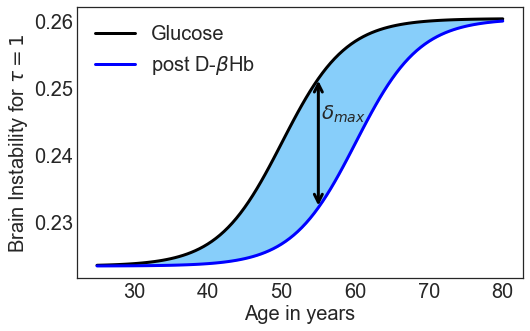

In [323]:
agex = np.linspace(35,90,100)
sig1 = sigmoid_Model.eval(out.params, x=agex)
shift_params = out.params.copy()
shift_params['switchpoint'].set(value=out.params['switchpoint'] +10)
sig2 = sigmoid_Model.eval(shift_params, x=agex)

plt.figure(figsize=(8,5))
ax = plt.gca()
plt.plot(agex-10,sig1,color="k",linewidth=3,label=r"Glucose")
plt.plot(agex-10,sig2,color="blue",linewidth=3,label=r"post D-$\beta$Hb")
ax.fill_between(agex-10,sig1,sig2,color="lightskyblue")
i_pointx, i_pointy ,i_pointya = (agex-10)[54],sig1[54],sig2[54]
y_diff = i_pointy - i_pointya
print(i_pointx,i_pointy,i_pointya,y_diff)
plt.annotate('', 
             xy=(55,i_pointya), 
             xycoords='data',
             xytext=(55,i_pointy), 
             arrowprops=dict(arrowstyle='<->',linewidth=3))

plt.annotate(r'$\delta_{max}$',
             xy=(55,0.24), 
             xycoords='data',
             xytext=(3,35),
             textcoords='offset points')

plt.legend()
plt.ylabel(r"Brain Instability for $\tau=1$")
plt.xlabel("Age in years")
plt.savefig("doublesig.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")
plt.savefig("doublesig.eps",format='eps',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later


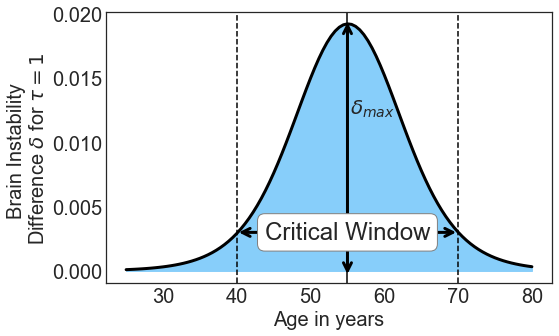

In [346]:
inst_diff = sig1-sig2
plt.figure(figsize=(8,5))
plt.plot(agex-10,inst_diff,color="k",linewidth=3)
ax = plt.gca()
ax.fill_between(agex-10,inst_diff,0,color="lightskyblue")
plt.axvline(x = 40,color='k',linestyle='--')
plt.axvline(x = 70,color='k',linestyle='--')
plt.axvline(x = 55,color='k',linestyle='-')
plt.annotate('', 
             xy=(55,-0.0004), 
             xycoords='data',
             xytext=(55,0.0195), 
             arrowprops=dict(arrowstyle='<->',linewidth=3))
plt.annotate('', 
             xy=(40,0.003), 
             xycoords='data',
             xytext=(70,0.003), 
             arrowprops=dict(arrowstyle='<->',linewidth=3))
plt.annotate(r'$\delta_{max}$',
             xy=(55,0.02), 
             xycoords='data',
             xytext=(3,-100),
             textcoords='offset points')
bbox_props = dict(boxstyle="round", fc="w", ec="0.5")
ax.text(55, 0.003, "Critical Window", 
        ha="center", va="center", size=24,
        bbox=bbox_props)

# plt.annotate(r'$W_{crit}$',
#              xy=(55,0.005), 
#              xycoords='data',
#              xytext=(5,-15),
#              textcoords='offset points')

plt.ylabel("Brain Instability \nDifference "r"$\delta$ for "r"$\tau=1$")
plt.xlabel("Age in years")
plt.savefig("difference.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")
plt.savefig("difference.eps",format='eps',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later


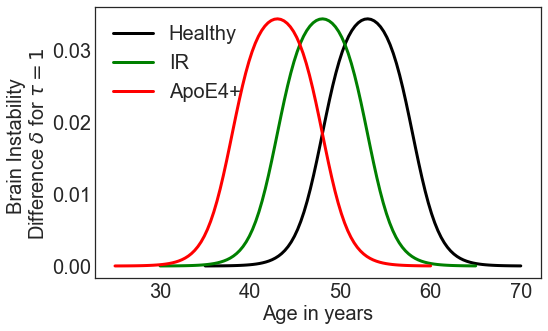

In [359]:
agex = np.linspace(40,75,100)
agei = agex-10
agea = agex-15
agec = [65,70]
bic = [0.26,0.223]
myparam = sigmoid_Model.make_params()
myparam['off'].set(value=0.22336927)
myparam['ampl'].set(value=0.03689264)
myparam['switchpoint'].set(value=53)
myparam['width'].set(value=1.5)
onset = interval_90*myparam['width']
sig1 = sigmoid_Model.eval(myparam, x=agex)
shift_params = myparam.copy()
shift_params['switchpoint'].set(value=myparam['switchpoint'] +10)
sig2 = sigmoid_Model.eval(shift_params, x=agex)
diff1 = sig1-sig2
plt.figure(figsize=(8,5))
plt.plot(agex-5,diff1,color="k",linewidth=3,label="Healthy")

plt.plot(agei,diff1,color="g",linewidth=3,label="IR")
plt.plot(agea,diff1,color="r",linewidth=3,label="ApoE4+")
plt.ylabel("Brain Instability \nDifference "r"$\delta$ for "r"$\tau=1$")
plt.xlabel("Age in years")
plt.legend(loc="upper left")
plt.savefig("conditions.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")
plt.savefig("conditions.eps",format='eps',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")